UMPM


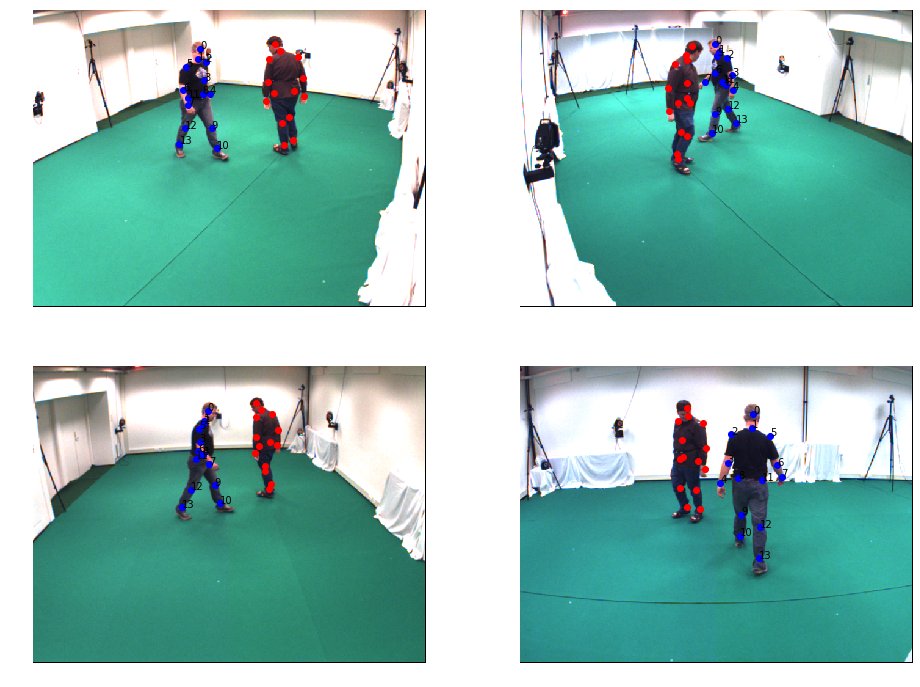

In [21]:
%matplotlib inline
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '../samples')
sys.path.insert(0, './')
from mvpose.data import umpm
from os.path import join
import numpy as np
from time import time

root = join(Settings['data_root'], 'pak')
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']
tmp = Settings['tmp']

FRAME = 1430
#FRAME = 0

X, Y, Calib = umpm.get(root, 'p2_free_1', user, pwd)
Imgs = [X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]]

gt1 = Y[FRAME, 0:14, 0:3].astype('float64')
gt2 = Y[FRAME, 14:, 0:3].astype('float64')

Per1_2d = []
Per1_3d = []

fig = plt.figure(figsize=(16, 12))
for cid, (cam, im) in enumerate(zip(Calib, Imgs)):
    ax = fig.add_subplot(2, 2, cid+1)
    ax.imshow(im)
    ax.axis('off')
    
    gt1_2d = cam.projectPoints(gt1)
    Per1_2d.append(gt1_2d[2:])
    Per1_3d.append(gt1[2:])
    gt2_2d = cam.projectPoints(gt2)
    ax.scatter(gt1_2d[:, 0], gt1_2d[:, 1], color='blue')
    ax.scatter(gt2_2d[:, 0], gt2_2d[:, 1], color='red')
    
    for jid, (x, y) in enumerate(gt1_2d):
        ax.text(x, y, str(jid))
    
plt.show()

In [24]:
Per1_2d = np.array(Per1_2d)
print('2d', Per1_2d.shape)

Per1_3d = np.array(Per1_3d)
print('3d', Per1_3d.shape)

2d (4, 12, 2)
3d (4, 12, 3)


In [38]:
from mvpose.data.base_poses import BasePoses
base_poses = BasePoses('../data/base_poses.txt')

L = base_poses.umpm(gt1)
for lid, s in enumerate(L):
    print((lid, s))

(0, 317.02554)
(1, 200.77211)
(2, 322.17545)
(3, 200.2671)
(4, 436.71298)
(5, 467.09518)
(6, 440.74475)
(7, 469.97607)
(8, 200.57106)
(9, 423.7941)
(10, 556.039)
(11, 541.2377)


In [43]:
X = np.ones((4, 1), np.float32)

Ps = np.array([cam.P.flatten() for cam in Calib])
Per1_2d = Per1_2d.reshape((4, -1))
Per1_3d = Per1_3d.reshape((4, -1))
L_ = np.array([L, L, L, L])
Y = np.concatenate([Ps, Per1_2d, L_], axis=1)

(4, 48)

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import mvpose.topdown.projective_optimization as po
from tensorflow.keras.optimizers import Adam, SGD

J = 12
model = Sequential()
o = Dense(J * 3, input_shape=(1,), use_bias=False)
model.add(o)

model.summary()

optimizer = SGD(lr=1)

model.compile(optimizer=optimizer,
              loss=po.loss_per_cameras,
              metrics=[po.loss_per_cameras])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 36)                36        
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X, Y, epochs=10000)

Epoch 1/10000
4/4 [==============================] - 0s 17ms/sample - loss: 462.2325 - loss_per_cameras: 462.2325
Epoch 2/10000
4/4 [==============================] - 0s 15ms/sample - loss: 461.8505 - loss_per_cameras: 461.8505
Epoch 3/10000
4/4 [==============================] - 0s 16ms/sample - loss: 461.4685 - loss_per_cameras: 461.4685
Epoch 4/10000
4/4 [==============================] - 0s 16ms/sample - loss: 461.0864 - loss_per_cameras: 461.0864
Epoch 5/10000
4/4 [==============================] - 0s 16ms/sample - loss: 460.7043 - loss_per_cameras: 460.7043
Epoch 6/10000
4/4 [==============================] - 0s 15ms/sample - loss: 460.3221 - loss_per_cameras: 460.3221
Epoch 7/10000
4/4 [==============================] - 0s 16ms/sample - loss: 459.9399 - loss_per_cameras: 459.9399
Epoch 8/10000
4/4 [==============================] - 0s 16ms/sample - loss: 459.5577 - loss_per_cameras: 459.5577
Epoch 9/10000
4/4 [==============================] - 0s 16ms/sample - loss: 459.1755 - l

Epoch 73/10000
4/4 [==============================] - 0s 14ms/sample - loss: 434.6724 - loss_per_cameras: 434.6724
Epoch 74/10000
4/4 [==============================] - 0s 16ms/sample - loss: 434.2891 - loss_per_cameras: 434.2891
Epoch 75/10000
4/4 [==============================] - 0s 16ms/sample - loss: 433.9057 - loss_per_cameras: 433.9057
Epoch 76/10000
4/4 [==============================] - 0s 16ms/sample - loss: 433.5223 - loss_per_cameras: 433.5223
Epoch 77/10000
4/4 [==============================] - 0s 15ms/sample - loss: 433.1390 - loss_per_cameras: 433.1390
Epoch 78/10000
4/4 [==============================] - 0s 15ms/sample - loss: 432.7556 - loss_per_cameras: 432.7556
Epoch 79/10000
4/4 [==============================] - 0s 16ms/sample - loss: 432.3722 - loss_per_cameras: 432.3722
Epoch 80/10000
4/4 [==============================] - 0s 16ms/sample - loss: 431.9888 - loss_per_cameras: 431.9888
Epoch 81/10000
4/4 [==============================] - 0s 16ms/sample - loss: 431

Epoch 144/10000
4/4 [==============================] - 0s 15ms/sample - loss: 407.4329 - loss_per_cameras: 407.4329
Epoch 145/10000
4/4 [==============================] - 0s 16ms/sample - loss: 407.0490 - loss_per_cameras: 407.0490
Epoch 146/10000
4/4 [==============================] - 0s 16ms/sample - loss: 406.6650 - loss_per_cameras: 406.6650
Epoch 147/10000
4/4 [==============================] - 0s 16ms/sample - loss: 406.2811 - loss_per_cameras: 406.2811
Epoch 148/10000
4/4 [==============================] - 0s 15ms/sample - loss: 405.8972 - loss_per_cameras: 405.8972
Epoch 149/10000
4/4 [==============================] - 0s 15ms/sample - loss: 405.5132 - loss_per_cameras: 405.5132
Epoch 150/10000
4/4 [==============================] - 0s 16ms/sample - loss: 405.1293 - loss_per_cameras: 405.1293
Epoch 151/10000
4/4 [==============================] - 0s 16ms/sample - loss: 404.7454 - loss_per_cameras: 404.7454
Epoch 152/10000
4/4 [==============================] - 0s 16ms/sample - 

Epoch 215/10000
4/4 [==============================] - 0s 15ms/sample - loss: 380.1628 - loss_per_cameras: 380.1628
Epoch 216/10000
4/4 [==============================] - 0s 16ms/sample - loss: 379.7785 - loss_per_cameras: 379.7785
Epoch 217/10000
4/4 [==============================] - 0s 16ms/sample - loss: 379.3943 - loss_per_cameras: 379.3943
Epoch 218/10000
4/4 [==============================] - 0s 16ms/sample - loss: 379.0100 - loss_per_cameras: 379.0100
Epoch 219/10000
4/4 [==============================] - 0s 16ms/sample - loss: 378.6258 - loss_per_cameras: 378.6258
Epoch 220/10000
4/4 [==============================] - 0s 15ms/sample - loss: 378.2416 - loss_per_cameras: 378.2416
Epoch 221/10000
4/4 [==============================] - 0s 16ms/sample - loss: 377.8573 - loss_per_cameras: 377.8573
Epoch 222/10000
4/4 [==============================] - 0s 16ms/sample - loss: 377.4730 - loss_per_cameras: 377.4730
Epoch 223/10000
4/4 [==============================] - 0s 16ms/sample - 

Epoch 286/10000
4/4 [==============================] - 0s 15ms/sample - loss: 352.8754 - loss_per_cameras: 352.8754
Epoch 287/10000
4/4 [==============================] - 0s 15ms/sample - loss: 352.4910 - loss_per_cameras: 352.4910
Epoch 288/10000
4/4 [==============================] - 0s 16ms/sample - loss: 352.1066 - loss_per_cameras: 352.1066
Epoch 289/10000
4/4 [==============================] - 0s 15ms/sample - loss: 351.7222 - loss_per_cameras: 351.7222
Epoch 290/10000
4/4 [==============================] - 0s 16ms/sample - loss: 351.3378 - loss_per_cameras: 351.3378
Epoch 291/10000
4/4 [==============================] - 0s 16ms/sample - loss: 350.9534 - loss_per_cameras: 350.9534
Epoch 292/10000
4/4 [==============================] - 0s 16ms/sample - loss: 350.5689 - loss_per_cameras: 350.5689
Epoch 293/10000
4/4 [==============================] - 0s 16ms/sample - loss: 350.1845 - loss_per_cameras: 350.1845
Epoch 294/10000
4/4 [==============================] - 0s 15ms/sample - 

Epoch 357/10000
4/4 [==============================] - 0s 15ms/sample - loss: 330.1786 - loss_per_cameras: 330.1786
Epoch 358/10000
4/4 [==============================] - 0s 16ms/sample - loss: 329.9023 - loss_per_cameras: 329.9023
Epoch 359/10000
4/4 [==============================] - 0s 16ms/sample - loss: 329.6260 - loss_per_cameras: 329.6260
Epoch 360/10000
4/4 [==============================] - 0s 16ms/sample - loss: 329.3497 - loss_per_cameras: 329.3497
Epoch 361/10000
4/4 [==============================] - 0s 16ms/sample - loss: 329.0735 - loss_per_cameras: 329.0735
Epoch 362/10000
4/4 [==============================] - 0s 16ms/sample - loss: 328.7972 - loss_per_cameras: 328.7972
Epoch 363/10000
4/4 [==============================] - 0s 16ms/sample - loss: 328.5209 - loss_per_cameras: 328.5209
Epoch 364/10000
4/4 [==============================] - 0s 16ms/sample - loss: 328.2446 - loss_per_cameras: 328.2446
Epoch 365/10000
4/4 [==============================] - 0s 16ms/sample - 

Epoch 428/10000
4/4 [==============================] - 0s 15ms/sample - loss: 310.5601 - loss_per_cameras: 310.5601
Epoch 429/10000
4/4 [==============================] - 0s 16ms/sample - loss: 310.2837 - loss_per_cameras: 310.2837
Epoch 430/10000
4/4 [==============================] - 0s 15ms/sample - loss: 310.0073 - loss_per_cameras: 310.0073
Epoch 431/10000
4/4 [==============================] - 0s 15ms/sample - loss: 309.7310 - loss_per_cameras: 309.7310
Epoch 432/10000
4/4 [==============================] - 0s 14ms/sample - loss: 309.4546 - loss_per_cameras: 309.4546
Epoch 433/10000
4/4 [==============================] - 0s 14ms/sample - loss: 309.1783 - loss_per_cameras: 309.1783
Epoch 434/10000
4/4 [==============================] - 0s 15ms/sample - loss: 308.9019 - loss_per_cameras: 308.9019
Epoch 435/10000
4/4 [==============================] - 0s 15ms/sample - loss: 308.6255 - loss_per_cameras: 308.6255
Epoch 436/10000
4/4 [==============================] - 0s 15ms/sample - 

Epoch 499/10000
4/4 [==============================] - 0s 16ms/sample - loss: 290.9363 - loss_per_cameras: 290.9363
Epoch 500/10000
4/4 [==============================] - 0s 16ms/sample - loss: 290.6599 - loss_per_cameras: 290.6599
Epoch 501/10000
4/4 [==============================] - 0s 15ms/sample - loss: 290.3835 - loss_per_cameras: 290.3835
Epoch 502/10000
4/4 [==============================] - 0s 16ms/sample - loss: 290.1071 - loss_per_cameras: 290.1071
Epoch 503/10000
4/4 [==============================] - 0s 16ms/sample - loss: 289.8307 - loss_per_cameras: 289.8307
Epoch 504/10000
4/4 [==============================] - 0s 16ms/sample - loss: 289.5543 - loss_per_cameras: 289.5543
Epoch 505/10000
4/4 [==============================] - 0s 15ms/sample - loss: 289.2779 - loss_per_cameras: 289.2779
Epoch 506/10000
4/4 [==============================] - 0s 16ms/sample - loss: 289.0015 - loss_per_cameras: 289.0015
Epoch 507/10000
4/4 [==============================] - 0s 15ms/sample - 

Epoch 570/10000
4/4 [==============================] - 0s 15ms/sample - loss: 271.3102 - loss_per_cameras: 271.3102
Epoch 571/10000
4/4 [==============================] - 0s 16ms/sample - loss: 271.0338 - loss_per_cameras: 271.0338
Epoch 572/10000
4/4 [==============================] - 0s 16ms/sample - loss: 270.7573 - loss_per_cameras: 270.7573
Epoch 573/10000
4/4 [==============================] - 0s 16ms/sample - loss: 270.4809 - loss_per_cameras: 270.4809
Epoch 574/10000
4/4 [==============================] - 0s 16ms/sample - loss: 270.2045 - loss_per_cameras: 270.2045
Epoch 575/10000
4/4 [==============================] - 0s 15ms/sample - loss: 269.9280 - loss_per_cameras: 269.9280
Epoch 576/10000
4/4 [==============================] - 0s 16ms/sample - loss: 269.6516 - loss_per_cameras: 269.6516
Epoch 577/10000
4/4 [==============================] - 0s 16ms/sample - loss: 269.3752 - loss_per_cameras: 269.3752
Epoch 578/10000
4/4 [==============================] - 0s 16ms/sample - 

Epoch 641/10000
4/4 [==============================] - 0s 15ms/sample - loss: 251.6835 - loss_per_cameras: 251.6835
Epoch 642/10000
4/4 [==============================] - 0s 16ms/sample - loss: 251.4071 - loss_per_cameras: 251.4071
Epoch 643/10000
4/4 [==============================] - 0s 16ms/sample - loss: 251.1306 - loss_per_cameras: 251.1306
Epoch 644/10000
4/4 [==============================] - 0s 16ms/sample - loss: 250.8542 - loss_per_cameras: 250.8542
Epoch 645/10000
4/4 [==============================] - 0s 16ms/sample - loss: 250.5778 - loss_per_cameras: 250.5778
Epoch 646/10000
4/4 [==============================] - 0s 15ms/sample - loss: 250.3014 - loss_per_cameras: 250.3014
Epoch 647/10000
4/4 [==============================] - 0s 16ms/sample - loss: 250.0249 - loss_per_cameras: 250.0249
Epoch 648/10000
4/4 [==============================] - 0s 16ms/sample - loss: 249.7485 - loss_per_cameras: 249.7485
Epoch 649/10000
4/4 [==============================] - 0s 16ms/sample - 

Epoch 712/10000
4/4 [==============================] - 0s 15ms/sample - loss: 237.7453 - loss_per_cameras: 237.7453
Epoch 713/10000
4/4 [==============================] - 0s 15ms/sample - loss: 237.6330 - loss_per_cameras: 237.6330
Epoch 714/10000
4/4 [==============================] - 0s 17ms/sample - loss: 237.5207 - loss_per_cameras: 237.5207
Epoch 715/10000
4/4 [==============================] - 0s 17ms/sample - loss: 237.4083 - loss_per_cameras: 237.4083
Epoch 716/10000
4/4 [==============================] - 0s 17ms/sample - loss: 237.2960 - loss_per_cameras: 237.2960
Epoch 717/10000
4/4 [==============================] - 0s 17ms/sample - loss: 237.1837 - loss_per_cameras: 237.1837
Epoch 718/10000
4/4 [==============================] - 0s 15ms/sample - loss: 237.0714 - loss_per_cameras: 237.0714
Epoch 719/10000
4/4 [==============================] - 0s 16ms/sample - loss: 236.9590 - loss_per_cameras: 236.9590
Epoch 720/10000
4/4 [==============================] - 0s 16ms/sample - 

Epoch 783/10000
4/4 [==============================] - 0s 15ms/sample - loss: 229.9245 - loss_per_cameras: 229.9245
Epoch 784/10000
4/4 [==============================] - 0s 16ms/sample - loss: 229.8185 - loss_per_cameras: 229.8185
Epoch 785/10000
4/4 [==============================] - 0s 15ms/sample - loss: 229.7139 - loss_per_cameras: 229.7139
Epoch 786/10000
4/4 [==============================] - 0s 16ms/sample - loss: 229.6015 - loss_per_cameras: 229.6015
Epoch 787/10000
4/4 [==============================] - 0s 16ms/sample - loss: 229.4891 - loss_per_cameras: 229.4891
Epoch 788/10000
4/4 [==============================] - 0s 16ms/sample - loss: 229.3841 - loss_per_cameras: 229.3841
Epoch 789/10000
4/4 [==============================] - 0s 16ms/sample - loss: 229.2786 - loss_per_cameras: 229.2786
Epoch 790/10000
4/4 [==============================] - 0s 17ms/sample - loss: 229.1662 - loss_per_cameras: 229.1662
Epoch 791/10000
4/4 [==============================] - 0s 16ms/sample - 

Epoch 854/10000
4/4 [==============================] - 0s 16ms/sample - loss: 222.4077 - loss_per_cameras: 222.4077
Epoch 855/10000
4/4 [==============================] - 0s 16ms/sample - loss: 222.3171 - loss_per_cameras: 222.3171
Epoch 856/10000
4/4 [==============================] - 0s 16ms/sample - loss: 222.2109 - loss_per_cameras: 222.2109
Epoch 857/10000
4/4 [==============================] - 0s 16ms/sample - loss: 222.0986 - loss_per_cameras: 222.0986
Epoch 858/10000
4/4 [==============================] - 0s 16ms/sample - loss: 221.9861 - loss_per_cameras: 221.9861
Epoch 859/10000
4/4 [==============================] - 0s 16ms/sample - loss: 221.8964 - loss_per_cameras: 221.8964
Epoch 860/10000
4/4 [==============================] - 0s 16ms/sample - loss: 221.7893 - loss_per_cameras: 221.7893
Epoch 861/10000
4/4 [==============================] - 0s 16ms/sample - loss: 221.6770 - loss_per_cameras: 221.6770
Epoch 862/10000
4/4 [==============================] - 0s 16ms/sample - 

Epoch 925/10000
4/4 [==============================] - 0s 15ms/sample - loss: 215.2362 - loss_per_cameras: 215.2362
Epoch 926/10000
4/4 [==============================] - 0s 15ms/sample - loss: 215.1385 - loss_per_cameras: 215.1385
Epoch 927/10000
4/4 [==============================] - 0s 17ms/sample - loss: 215.0611 - loss_per_cameras: 215.0611
Epoch 928/10000
4/4 [==============================] - 0s 16ms/sample - loss: 214.9549 - loss_per_cameras: 214.9549
Epoch 929/10000
4/4 [==============================] - 0s 17ms/sample - loss: 214.8709 - loss_per_cameras: 214.8709
Epoch 930/10000
4/4 [==============================] - 0s 16ms/sample - loss: 214.7715 - loss_per_cameras: 214.7715
Epoch 931/10000
4/4 [==============================] - 0s 15ms/sample - loss: 214.6945 - loss_per_cameras: 214.6945
Epoch 932/10000
4/4 [==============================] - 0s 15ms/sample - loss: 214.5878 - loss_per_cameras: 214.5878
Epoch 933/10000
4/4 [==============================] - 0s 16ms/sample - 

Epoch 996/10000
4/4 [==============================] - 0s 15ms/sample - loss: 208.7300 - loss_per_cameras: 208.7300
Epoch 997/10000
4/4 [==============================] - 0s 16ms/sample - loss: 208.6421 - loss_per_cameras: 208.6421
Epoch 998/10000
4/4 [==============================] - 0s 15ms/sample - loss: 208.5370 - loss_per_cameras: 208.5370
Epoch 999/10000
4/4 [==============================] - 0s 15ms/sample - loss: 208.4533 - loss_per_cameras: 208.4533
Epoch 1000/10000
4/4 [==============================] - 0s 16ms/sample - loss: 208.3646 - loss_per_cameras: 208.3646
Epoch 1001/10000
4/4 [==============================] - 0s 15ms/sample - loss: 208.2747 - loss_per_cameras: 208.2747
Epoch 1002/10000
4/4 [==============================] - 0s 15ms/sample - loss: 208.1703 - loss_per_cameras: 208.1703
Epoch 1003/10000
4/4 [==============================] - 0s 16ms/sample - loss: 208.0860 - loss_per_cameras: 208.0860
Epoch 1004/10000
4/4 [==============================] - 0s 16ms/samp

4/4 [==============================] - 0s 15ms/sample - loss: 202.3055 - loss_per_cameras: 202.3055
Epoch 1067/10000
4/4 [==============================] - 0s 15ms/sample - loss: 202.2198 - loss_per_cameras: 202.2198
Epoch 1068/10000
4/4 [==============================] - 0s 16ms/sample - loss: 202.1306 - loss_per_cameras: 202.1306
Epoch 1069/10000
4/4 [==============================] - 0s 15ms/sample - loss: 202.0269 - loss_per_cameras: 202.0269
Epoch 1070/10000
4/4 [==============================] - 0s 16ms/sample - loss: 201.9398 - loss_per_cameras: 201.9398
Epoch 1071/10000
4/4 [==============================] - 0s 16ms/sample - loss: 201.8521 - loss_per_cameras: 201.8521
Epoch 1072/10000
4/4 [==============================] - 0s 16ms/sample - loss: 201.7636 - loss_per_cameras: 201.7636
Epoch 1073/10000
4/4 [==============================] - 0s 16ms/sample - loss: 201.6592 - loss_per_cameras: 201.6592
Epoch 1074/10000
4/4 [==============================] - 0s 15ms/sample - loss: 20

Epoch 1137/10000
4/4 [==============================] - 0s 15ms/sample - loss: 195.8626 - loss_per_cameras: 195.8626
Epoch 1138/10000
4/4 [==============================] - 0s 16ms/sample - loss: 195.7540 - loss_per_cameras: 195.7540
Epoch 1139/10000
4/4 [==============================] - 0s 16ms/sample - loss: 195.6754 - loss_per_cameras: 195.6754
Epoch 1140/10000
4/4 [==============================] - 0s 16ms/sample - loss: 195.5771 - loss_per_cameras: 195.5771
Epoch 1141/10000
4/4 [==============================] - 0s 17ms/sample - loss: 195.5107 - loss_per_cameras: 195.5107
Epoch 1142/10000
4/4 [==============================] - 0s 16ms/sample - loss: 195.3996 - loss_per_cameras: 195.3996
Epoch 1143/10000
4/4 [==============================] - 0s 16ms/sample - loss: 195.3018 - loss_per_cameras: 195.3018
Epoch 1144/10000
4/4 [==============================] - 0s 15ms/sample - loss: 195.2154 - loss_per_cameras: 195.2154
Epoch 1145/10000
4/4 [==============================] - 0s 15ms/

4/4 [==============================] - 0s 15ms/sample - loss: 189.5710 - loss_per_cameras: 189.5710
Epoch 1208/10000
4/4 [==============================] - 0s 16ms/sample - loss: 189.5103 - loss_per_cameras: 189.5103
Epoch 1209/10000
4/4 [==============================] - 0s 16ms/sample - loss: 189.4026 - loss_per_cameras: 189.4026
Epoch 1210/10000
4/4 [==============================] - 0s 16ms/sample - loss: 189.3425 - loss_per_cameras: 189.3425
Epoch 1211/10000
4/4 [==============================] - 0s 16ms/sample - loss: 189.2342 - loss_per_cameras: 189.2342
Epoch 1212/10000
4/4 [==============================] - 0s 16ms/sample - loss: 189.1746 - loss_per_cameras: 189.1746
Epoch 1213/10000
4/4 [==============================] - 0s 16ms/sample - loss: 189.0657 - loss_per_cameras: 189.0657
Epoch 1214/10000
4/4 [==============================] - 0s 16ms/sample - loss: 189.0067 - loss_per_cameras: 189.0067
Epoch 1215/10000
4/4 [==============================] - 0s 16ms/sample - loss: 18

Epoch 1278/10000
4/4 [==============================] - 0s 15ms/sample - loss: 183.5968 - loss_per_cameras: 183.5968
Epoch 1279/10000
4/4 [==============================] - 0s 16ms/sample - loss: 183.5715 - loss_per_cameras: 183.5715
Epoch 1280/10000
4/4 [==============================] - 0s 15ms/sample - loss: 183.4277 - loss_per_cameras: 183.4277
Epoch 1281/10000
4/4 [==============================] - 0s 15ms/sample - loss: 183.3767 - loss_per_cameras: 183.3767
Epoch 1282/10000
4/4 [==============================] - 0s 16ms/sample - loss: 183.2588 - loss_per_cameras: 183.2588
Epoch 1283/10000
4/4 [==============================] - 0s 17ms/sample - loss: 183.2092 - loss_per_cameras: 183.2092
Epoch 1284/10000
4/4 [==============================] - 0s 16ms/sample - loss: 183.0906 - loss_per_cameras: 183.0906
Epoch 1285/10000
4/4 [==============================] - 0s 16ms/sample - loss: 183.0140 - loss_per_cameras: 183.0140
Epoch 1286/10000
4/4 [==============================] - 0s 15ms/

4/4 [==============================] - 0s 16ms/sample - loss: 177.7247 - loss_per_cameras: 177.7247
Epoch 1349/10000
4/4 [==============================] - 0s 16ms/sample - loss: 177.6386 - loss_per_cameras: 177.6386
Epoch 1350/10000
4/4 [==============================] - 0s 16ms/sample - loss: 177.5557 - loss_per_cameras: 177.5557
Epoch 1351/10000
4/4 [==============================] - 0s 15ms/sample - loss: 177.4710 - loss_per_cameras: 177.4710
Epoch 1352/10000
4/4 [==============================] - 0s 14ms/sample - loss: 177.3867 - loss_per_cameras: 177.3867
Epoch 1353/10000
4/4 [==============================] - 0s 15ms/sample - loss: 177.3034 - loss_per_cameras: 177.3034
Epoch 1354/10000
4/4 [==============================] - 0s 16ms/sample - loss: 177.2176 - loss_per_cameras: 177.2176
Epoch 1355/10000
4/4 [==============================] - 0s 17ms/sample - loss: 177.1358 - loss_per_cameras: 177.1358
Epoch 1356/10000
4/4 [==============================] - 0s 16ms/sample - loss: 17

Epoch 1419/10000
4/4 [==============================] - 0s 16ms/sample - loss: 173.1924 - loss_per_cameras: 173.1924
Epoch 1420/10000
4/4 [==============================] - 0s 16ms/sample - loss: 173.1551 - loss_per_cameras: 173.1551
Epoch 1421/10000
4/4 [==============================] - 0s 15ms/sample - loss: 173.1375 - loss_per_cameras: 173.1375
Epoch 1422/10000
4/4 [==============================] - 0s 16ms/sample - loss: 173.1142 - loss_per_cameras: 173.1142
Epoch 1423/10000
4/4 [==============================] - 0s 17ms/sample - loss: 173.1047 - loss_per_cameras: 173.1047
Epoch 1424/10000
4/4 [==============================] - 0s 17ms/sample - loss: 173.0714 - loss_per_cameras: 173.0714
Epoch 1425/10000
4/4 [==============================] - 0s 17ms/sample - loss: 173.0478 - loss_per_cameras: 173.0478
Epoch 1426/10000
4/4 [==============================] - 0s 17ms/sample - loss: 173.0319 - loss_per_cameras: 173.0319
Epoch 1427/10000
4/4 [==============================] - 0s 16ms/

4/4 [==============================] - 0s 15ms/sample - loss: 171.6802 - loss_per_cameras: 171.6802
Epoch 1490/10000
4/4 [==============================] - 0s 15ms/sample - loss: 171.6927 - loss_per_cameras: 171.6927
Epoch 1491/10000
4/4 [==============================] - 0s 16ms/sample - loss: 171.6261 - loss_per_cameras: 171.6261
Epoch 1492/10000
4/4 [==============================] - 0s 16ms/sample - loss: 171.6453 - loss_per_cameras: 171.6453
Epoch 1493/10000
4/4 [==============================] - 0s 16ms/sample - loss: 171.5937 - loss_per_cameras: 171.5937
Epoch 1494/10000
4/4 [==============================] - 0s 16ms/sample - loss: 171.6091 - loss_per_cameras: 171.6091
Epoch 1495/10000
4/4 [==============================] - 0s 16ms/sample - loss: 171.5383 - loss_per_cameras: 171.5383
Epoch 1496/10000
4/4 [==============================] - 0s 16ms/sample - loss: 171.5597 - loss_per_cameras: 171.5597
Epoch 1497/10000
4/4 [==============================] - 0s 16ms/sample - loss: 17

Epoch 1560/10000
4/4 [==============================] - 0s 15ms/sample - loss: 170.1529 - loss_per_cameras: 170.1529
Epoch 1561/10000
4/4 [==============================] - 0s 16ms/sample - loss: 170.1433 - loss_per_cameras: 170.1433
Epoch 1562/10000
4/4 [==============================] - 0s 16ms/sample - loss: 170.0970 - loss_per_cameras: 170.0970
Epoch 1563/10000
4/4 [==============================] - 0s 16ms/sample - loss: 170.1058 - loss_per_cameras: 170.1058
Epoch 1564/10000
4/4 [==============================] - 0s 15ms/sample - loss: 170.0687 - loss_per_cameras: 170.0687
Epoch 1565/10000
4/4 [==============================] - 0s 16ms/sample - loss: 170.0563 - loss_per_cameras: 170.0563
Epoch 1566/10000
4/4 [==============================] - 0s 16ms/sample - loss: 170.0128 - loss_per_cameras: 170.0128
Epoch 1567/10000
4/4 [==============================] - 0s 16ms/sample - loss: 170.0180 - loss_per_cameras: 170.0180
Epoch 1568/10000
4/4 [==============================] - 0s 16ms/

4/4 [==============================] - 0s 15ms/sample - loss: 168.6897 - loss_per_cameras: 168.6897
Epoch 1631/10000
4/4 [==============================] - 0s 15ms/sample - loss: 168.6402 - loss_per_cameras: 168.6402
Epoch 1632/10000
4/4 [==============================] - 0s 16ms/sample - loss: 168.6342 - loss_per_cameras: 168.6342
Epoch 1633/10000
4/4 [==============================] - 0s 16ms/sample - loss: 168.5867 - loss_per_cameras: 168.5867
Epoch 1634/10000
4/4 [==============================] - 0s 17ms/sample - loss: 168.6062 - loss_per_cameras: 168.6062
Epoch 1635/10000
4/4 [==============================] - 0s 16ms/sample - loss: 168.5536 - loss_per_cameras: 168.5536
Epoch 1636/10000
4/4 [==============================] - 0s 16ms/sample - loss: 168.5228 - loss_per_cameras: 168.5228
Epoch 1637/10000
4/4 [==============================] - 0s 16ms/sample - loss: 168.5028 - loss_per_cameras: 168.5028
Epoch 1638/10000
4/4 [==============================] - 0s 16ms/sample - loss: 16

Epoch 1701/10000
4/4 [==============================] - 0s 15ms/sample - loss: 167.1489 - loss_per_cameras: 167.1489
Epoch 1702/10000
4/4 [==============================] - 0s 16ms/sample - loss: 167.1336 - loss_per_cameras: 167.1336
Epoch 1703/10000
4/4 [==============================] - 0s 16ms/sample - loss: 167.0913 - loss_per_cameras: 167.0913
Epoch 1704/10000
4/4 [==============================] - 0s 16ms/sample - loss: 167.0853 - loss_per_cameras: 167.0853
Epoch 1705/10000
4/4 [==============================] - 0s 16ms/sample - loss: 167.0545 - loss_per_cameras: 167.0545
Epoch 1706/10000
4/4 [==============================] - 0s 16ms/sample - loss: 167.0573 - loss_per_cameras: 167.0573
Epoch 1707/10000
4/4 [==============================] - 0s 16ms/sample - loss: 167.0108 - loss_per_cameras: 167.0108
Epoch 1708/10000
4/4 [==============================] - 0s 16ms/sample - loss: 167.0018 - loss_per_cameras: 167.0018
Epoch 1709/10000
4/4 [==============================] - 0s 16ms/

4/4 [==============================] - 0s 15ms/sample - loss: 165.6056 - loss_per_cameras: 165.6056
Epoch 1772/10000
4/4 [==============================] - 0s 16ms/sample - loss: 165.6407 - loss_per_cameras: 165.6407
Epoch 1773/10000
4/4 [==============================] - 0s 17ms/sample - loss: 165.5773 - loss_per_cameras: 165.5773
Epoch 1774/10000
4/4 [==============================] - 0s 16ms/sample - loss: 165.5887 - loss_per_cameras: 165.5887
Epoch 1775/10000
4/4 [==============================] - 0s 16ms/sample - loss: 165.5215 - loss_per_cameras: 165.5215
Epoch 1776/10000
4/4 [==============================] - 0s 16ms/sample - loss: 165.5527 - loss_per_cameras: 165.5527
Epoch 1777/10000
4/4 [==============================] - 0s 16ms/sample - loss: 165.4931 - loss_per_cameras: 165.4931
Epoch 1778/10000
4/4 [==============================] - 0s 16ms/sample - loss: 165.5019 - loss_per_cameras: 165.5019
Epoch 1779/10000
4/4 [==============================] - 0s 16ms/sample - loss: 16

Epoch 1842/10000
4/4 [==============================] - 0s 15ms/sample - loss: 164.1387 - loss_per_cameras: 164.1387
Epoch 1843/10000
4/4 [==============================] - 0s 15ms/sample - loss: 164.0941 - loss_per_cameras: 164.0941
Epoch 1844/10000
4/4 [==============================] - 0s 16ms/sample - loss: 164.1051 - loss_per_cameras: 164.1051
Epoch 1845/10000
4/4 [==============================] - 0s 16ms/sample - loss: 164.0421 - loss_per_cameras: 164.0421
Epoch 1846/10000
4/4 [==============================] - 0s 16ms/sample - loss: 164.0553 - loss_per_cameras: 164.0553
Epoch 1847/10000
4/4 [==============================] - 0s 16ms/sample - loss: 164.0054 - loss_per_cameras: 164.0054
Epoch 1848/10000
4/4 [==============================] - 0s 16ms/sample - loss: 164.0203 - loss_per_cameras: 164.0203
Epoch 1849/10000
4/4 [==============================] - 0s 16ms/sample - loss: 163.9563 - loss_per_cameras: 163.9563
Epoch 1850/10000
4/4 [==============================] - 0s 16ms/

4/4 [==============================] - 0s 15ms/sample - loss: 162.6325 - loss_per_cameras: 162.6325
Epoch 1913/10000
4/4 [==============================] - 0s 16ms/sample - loss: 162.6002 - loss_per_cameras: 162.6002
Epoch 1914/10000
4/4 [==============================] - 0s 16ms/sample - loss: 162.5905 - loss_per_cameras: 162.5905
Epoch 1915/10000
4/4 [==============================] - 0s 16ms/sample - loss: 162.5580 - loss_per_cameras: 162.5580
Epoch 1916/10000
4/4 [==============================] - 0s 16ms/sample - loss: 162.5464 - loss_per_cameras: 162.5464
Epoch 1917/10000
4/4 [==============================] - 0s 16ms/sample - loss: 162.5168 - loss_per_cameras: 162.5168
Epoch 1918/10000
4/4 [==============================] - 0s 16ms/sample - loss: 162.5013 - loss_per_cameras: 162.5013
Epoch 1919/10000
4/4 [==============================] - 0s 16ms/sample - loss: 162.4736 - loss_per_cameras: 162.4736
Epoch 1920/10000
4/4 [==============================] - 0s 16ms/sample - loss: 16

Epoch 1983/10000
4/4 [==============================] - 0s 15ms/sample - loss: 161.1132 - loss_per_cameras: 161.1132
Epoch 1984/10000
4/4 [==============================] - 0s 16ms/sample - loss: 161.0593 - loss_per_cameras: 161.0593
Epoch 1985/10000
4/4 [==============================] - 0s 17ms/sample - loss: 161.0861 - loss_per_cameras: 161.0861
Epoch 1986/10000
4/4 [==============================] - 0s 17ms/sample - loss: 161.0078 - loss_per_cameras: 161.0078
Epoch 1987/10000
4/4 [==============================] - 0s 17ms/sample - loss: 161.0554 - loss_per_cameras: 161.0554
Epoch 1988/10000
4/4 [==============================] - 0s 16ms/sample - loss: 160.9718 - loss_per_cameras: 160.9718
Epoch 1989/10000
4/4 [==============================] - 0s 15ms/sample - loss: 161.0027 - loss_per_cameras: 161.0027
Epoch 1990/10000
4/4 [==============================] - 0s 16ms/sample - loss: 160.9175 - loss_per_cameras: 160.9175
Epoch 1991/10000
4/4 [==============================] - 0s 16ms/

4/4 [==============================] - 0s 15ms/sample - loss: 159.6072 - loss_per_cameras: 159.6072
Epoch 2054/10000
4/4 [==============================] - 0s 15ms/sample - loss: 159.5820 - loss_per_cameras: 159.5820
Epoch 2055/10000
4/4 [==============================] - 0s 16ms/sample - loss: 159.5730 - loss_per_cameras: 159.5730
Epoch 2056/10000
4/4 [==============================] - 0s 15ms/sample - loss: 159.5277 - loss_per_cameras: 159.5277
Epoch 2057/10000
4/4 [==============================] - 0s 15ms/sample - loss: 159.5237 - loss_per_cameras: 159.5237
Epoch 2058/10000
4/4 [==============================] - 0s 15ms/sample - loss: 159.4930 - loss_per_cameras: 159.4930
Epoch 2059/10000
4/4 [==============================] - 0s 15ms/sample - loss: 159.4881 - loss_per_cameras: 159.4881
Epoch 2060/10000
4/4 [==============================] - 0s 16ms/sample - loss: 159.4417 - loss_per_cameras: 159.4417
Epoch 2061/10000
4/4 [==============================] - 0s 15ms/sample - loss: 15

Epoch 2124/10000
4/4 [==============================] - 0s 16ms/sample - loss: 158.0713 - loss_per_cameras: 158.0713
Epoch 2125/10000
4/4 [==============================] - 0s 16ms/sample - loss: 158.0448 - loss_per_cameras: 158.0448
Epoch 2126/10000
4/4 [==============================] - 0s 16ms/sample - loss: 158.0247 - loss_per_cameras: 158.0247
Epoch 2127/10000
4/4 [==============================] - 0s 16ms/sample - loss: 158.0038 - loss_per_cameras: 158.0038
Epoch 2128/10000
4/4 [==============================] - 0s 16ms/sample - loss: 158.0154 - loss_per_cameras: 158.0154
Epoch 2129/10000
4/4 [==============================] - 0s 16ms/sample - loss: 157.9763 - loss_per_cameras: 157.9763
Epoch 2130/10000
4/4 [==============================] - 0s 16ms/sample - loss: 157.9935 - loss_per_cameras: 157.9935
Epoch 2131/10000
4/4 [==============================] - 0s 16ms/sample - loss: 157.9620 - loss_per_cameras: 157.9620
Epoch 2132/10000
4/4 [==============================] - 0s 16ms/

4/4 [==============================] - 0s 15ms/sample - loss: 157.3038 - loss_per_cameras: 157.3038
Epoch 2195/10000
4/4 [==============================] - 0s 15ms/sample - loss: 157.2749 - loss_per_cameras: 157.2749
Epoch 2196/10000
4/4 [==============================] - 0s 16ms/sample - loss: 157.2798 - loss_per_cameras: 157.2798
Epoch 2197/10000
4/4 [==============================] - 0s 15ms/sample - loss: 157.2462 - loss_per_cameras: 157.2462
Epoch 2198/10000
4/4 [==============================] - 0s 16ms/sample - loss: 157.2584 - loss_per_cameras: 157.2584
Epoch 2199/10000
4/4 [==============================] - 0s 16ms/sample - loss: 157.2306 - loss_per_cameras: 157.2306
Epoch 2200/10000
4/4 [==============================] - 0s 16ms/sample - loss: 157.2378 - loss_per_cameras: 157.2378
Epoch 2201/10000
4/4 [==============================] - 0s 16ms/sample - loss: 157.2019 - loss_per_cameras: 157.2019
Epoch 2202/10000
4/4 [==============================] - 0s 16ms/sample - loss: 15

Epoch 2265/10000
4/4 [==============================] - 0s 15ms/sample - loss: 156.5798 - loss_per_cameras: 156.5798
Epoch 2266/10000
4/4 [==============================] - 0s 15ms/sample - loss: 156.6396 - loss_per_cameras: 156.6396
Epoch 2267/10000
4/4 [==============================] - 0s 14ms/sample - loss: 156.5785 - loss_per_cameras: 156.5785
Epoch 2268/10000
4/4 [==============================] - 0s 14ms/sample - loss: 156.6347 - loss_per_cameras: 156.6347
Epoch 2269/10000
4/4 [==============================] - 0s 15ms/sample - loss: 156.5764 - loss_per_cameras: 156.5764
Epoch 2270/10000
4/4 [==============================] - 0s 15ms/sample - loss: 156.6323 - loss_per_cameras: 156.6323
Epoch 2271/10000
4/4 [==============================] - 0s 14ms/sample - loss: 156.5719 - loss_per_cameras: 156.5719
Epoch 2272/10000
4/4 [==============================] - 0s 16ms/sample - loss: 156.6299 - loss_per_cameras: 156.6299
Epoch 2273/10000
4/4 [==============================] - 0s 14ms/

4/4 [==============================] - 0s 15ms/sample - loss: 156.5093 - loss_per_cameras: 156.5093
Epoch 2336/10000
4/4 [==============================] - 0s 16ms/sample - loss: 156.4982 - loss_per_cameras: 156.4982
Epoch 2337/10000
4/4 [==============================] - 0s 16ms/sample - loss: 156.5053 - loss_per_cameras: 156.5053
Epoch 2338/10000
4/4 [==============================] - 0s 16ms/sample - loss: 156.4953 - loss_per_cameras: 156.4953
Epoch 2339/10000
4/4 [==============================] - 0s 16ms/sample - loss: 156.5288 - loss_per_cameras: 156.5288
Epoch 2340/10000
4/4 [==============================] - 0s 16ms/sample - loss: 156.4926 - loss_per_cameras: 156.4926
Epoch 2341/10000
4/4 [==============================] - 0s 16ms/sample - loss: 156.5242 - loss_per_cameras: 156.5242
Epoch 2342/10000
4/4 [==============================] - 0s 16ms/sample - loss: 156.4899 - loss_per_cameras: 156.4899
Epoch 2343/10000
4/4 [==============================] - 0s 15ms/sample - loss: 15

Epoch 2406/10000
4/4 [==============================] - 0s 15ms/sample - loss: 156.4002 - loss_per_cameras: 156.4002
Epoch 2407/10000
4/4 [==============================] - 0s 16ms/sample - loss: 156.3799 - loss_per_cameras: 156.3799
Epoch 2408/10000
4/4 [==============================] - 0s 16ms/sample - loss: 156.3955 - loss_per_cameras: 156.3955
Epoch 2409/10000
4/4 [==============================] - 0s 16ms/sample - loss: 156.3770 - loss_per_cameras: 156.3770
Epoch 2410/10000
4/4 [==============================] - 0s 15ms/sample - loss: 156.3920 - loss_per_cameras: 156.3920
Epoch 2411/10000
4/4 [==============================] - 0s 17ms/sample - loss: 156.3724 - loss_per_cameras: 156.3724
Epoch 2412/10000
4/4 [==============================] - 0s 16ms/sample - loss: 156.3898 - loss_per_cameras: 156.3898
Epoch 2413/10000
4/4 [==============================] - 0s 16ms/sample - loss: 156.3689 - loss_per_cameras: 156.3689
Epoch 2414/10000
4/4 [==============================] - 0s 16ms/